In [2]:
import hashlib
import time
import os
import pickle
import sys
sys.path.append("/home/tuev/CODE/lcodePy/")

In [2]:
def dump_data_checksum(filename, data):
    '''
    Save hash sum of data, that assumed to be correct

    Parametrs
    ---------
    filename : String
            Checksum will be writen in ./checksums/filename.
    data : Dict
            Correct data to be saved in the form {key : md5(data[key])}. 
    '''
    try:
        os.mkdir("checksums")
    except:
        pass
    file_path = f'checksums/{filename}'
    data_checksum = {}
    for key, value in data.items():
        data_checksum[key] = hashlib.md5(value).hexdigest()
    with open(file_path, 'wb') as f:
        pickle.dump(data_checksum, f)

def check_data(filename, data):
    '''
    Verify the data by the stored checksum.

    Parametrs
    ---------
    filename : String
            Checksum will be loaded from ./checksums/filename.
    data : Dict
            Data to be virified. 
            the cehck is performed as md5(data[key]) ? loaded_checksum[key]. 
    '''
    OKGREEN = '\033[92m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    file_path = f"checksums/{filename}"
    if not os.path.isfile(file_path):
        print(f"File '{file_path}' does not exist.")
        return
    data_checksum = {}
    for key, value in data.items():
        data_checksum[key] = hashlib.md5(value).hexdigest()
    with open(file_path, 'rb') as f:
        expected_data = pickle.load(f)
    for key, value in expected_data.items():
        if value == data_checksum[key]:
            print(f'{OKGREEN}{key} is OK!{ENDC}')
        else:
            print(f'{FAIL}Expected {key} differs from resived!{ENDC}')
    

## LcodePy 2D

In [3]:
import os
os.environ['NUMBA_NUM_THREADS']='1'
os.environ['MKL_NUM_THREADS']='1'
from lcode.simulation import Simulation
from lcode.diagnostics.targets import BeamDiagnostics, FieldDiagnostics, PlasmaDiagnostics
from lcode.config.config import Config
# Set some parameters of the config:
config = {
    'geometry': '2d',
    'processing-unit-type': 'cpu',
    
    'window-width-step-size': 0.02,
    'window-width': 16,

    'window-length': 5,
    'xi-step': 0.02,

    'time-limit': 2,
    'time-step': 1,

    'plasma-particles-per-cell': 4,
}

beam_parameters = {'current': 1, 'particles_in_layer': 1000}

# Set diagnostics
conf = Config(config)
diagnostics = [
    BeamDiagnostics(conf, period=2),
    FieldDiagnostics(conf, "E_r", r=20, period=2),
    FieldDiagnostics(conf, "E_f", r=20, period=2),
    FieldDiagnostics(conf, "E_z", r=20, period=2)
]

sim = Simulation(config=config, diagnostics=diagnostics,
                 beam_parameters=beam_parameters)

sim.step();

Since the number of time steps hasn't been set explicitly, the code will simulate 2 time steps with a time step size = 1.0.
t=+1.0000, xi=+0.0000 Ez=-5.6429440994169210e-12
t=+1.0000, xi=-0.0200 Ez=-2.2377068833302428e-06
t=+1.0000, xi=-0.0400 Ez=-3.5971931184712649e-05
t=+1.0000, xi=-0.0600 Ez=-1.2663877908499719e-04
t=+1.0000, xi=-0.0800 Ez=-3.1592843003681815e-04
t=+1.0000, xi=-0.1000 Ez=-6.6507085719075341e-04
t=+1.0000, xi=-0.1200 Ez=-1.0578036857512255e-03
t=+1.0000, xi=-0.1400 Ez=-1.6055538458178444e-03
t=+1.0000, xi=-0.1600 Ez=-2.4872787698399699e-03
t=+1.0000, xi=-0.1800 Ez=-3.6107140284286502e-03
t=+1.0000, xi=-0.2000 Ez=-4.9991817913781792e-03
t=+1.0000, xi=-0.2200 Ez=-6.5532364286342995e-03
t=+1.0000, xi=-0.2400 Ez=-8.4024877631887832e-03
t=+1.0000, xi=-0.2600 Ez=-1.0691538338957056e-02
t=+1.0000, xi=-0.2800 Ez=-1.3340025967917446e-02
t=+1.0000, xi=-0.3000 Ez=-1.6513734419919632e-02
t=+1.0000, xi=-0.3200 Ez=-2.0009576953451163e-02
t=+1.0000, xi=-0.3400 Ez=-2.389293922501706

In [4]:
time_limit = conf.getfloat('time-limit')
time_step = conf.getfloat('time-step')
t = 2
data = {}
for key in diagnostics[0].data[t].dtype.names:
    data['beam_'+key] = diagnostics[0].data[t][key].copy(order='C')
data['E_r'] = diagnostics[1].data[t]
data['E_f'] = diagnostics[2].data[t]
data['E_z'] = diagnostics[3].data[t]
#plasma = diagnostics[4].data[t]

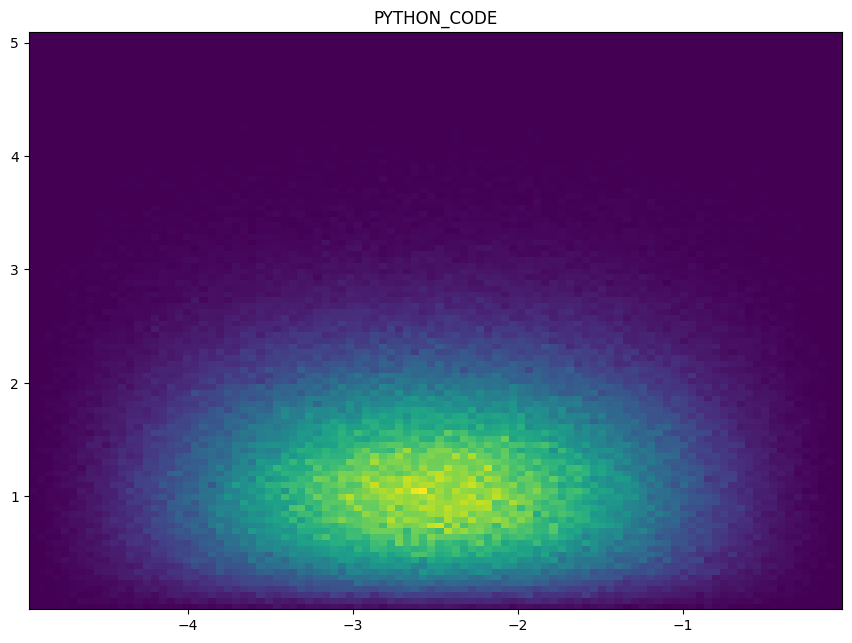

In [5]:
import matplotlib.pyplot as plt
bins = 100
py_hist = plt.hist2d(data['beam_xi'], data['beam_r'], bins=bins)[0]
plt.title('PYTHON_CODE')

fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
plt.plot();

In [6]:
dump_data_checksum("test2d", data)

In [7]:
check_data("test2d", data) 

beam_xi is OK!
beam_r is OK!
beam_p_z is OK!
beam_p_r is OK!
beam_M is OK!
beam_q_m is OK!
beam_q_norm is OK!
beam_id is OK!
E_r is OK!
E_f is OK!
E_z is OK!


In [ ]:
PAS = PusherAndSolver(config)
fields, particles = init_plasma(config)
particles, fields = PAS.step_dt(particles, fields, beam_source, beam_drain, 0)

## LcodePy 3D

In [3]:
# test jit compilition time

start_time = time.time()

import warnings
warnings.filterwarnings('ignore', '.*Grid size.*', )

import os
os.environ['NUMBA_NUM_THREADS']='3'
os.environ['MKL_NUM_THREADS']='3'


# Import required modules
from lcode.simulation import Simulation

# Set some parameters of the config:
config = {
    'geometry': '3d',
    'processing-unit-type': 'cpu',
    
    'window-width-step-size': 0.02,
    'window-width': 5,

    'window-length': 0.02,
    'xi-step': 0.02,

    'time-limit': 1,
    'time-step': 1,

    'plasma-particles-per-cell': 4,
}

# Set beam parameters
beam_parameters = {'current': 0.01 * (2*3.14), 'particles_in_layer': 5000}

# Set diagnostics
diag = []
sim = Simulation(config=config, diagnostics=diag,
                 beam_parameters=beam_parameters)
sim.step()
print(f"--- {((time.time() - start_time) / 7.486461400985718)} relative diff in compilation time ---")

Since the number of time steps hasn't been set explicitly, the code will simulate 1 time steps with a time step size = 1.0.


c:\users\nikita\desktop\lcodepy\lcode\plasma3d\initialization.py:64: RuntimeWarning: divide by zero encountered in divide
  mul = 1 / (lambda_i + lambda_j)  # WARNING: zero division in mul[0, 0]!


t=+1.0000, xi=+0.0000 Ez=-0.0000000000000000e+00
t=+1.0000, xi=-0.0200 Ez=-1.1219541333919889e-07
The work is done!
--- 2.3115317131147135 relative diff in compilation time ---


In [4]:
# test calculation time

start_time = time.time()

# Set some parameters of the config:
config = {
    'geometry': '3d',
    'processing-unit-type': 'cpu',
    
    'window-width-step-size': 0.02,
    'window-width': 5,

    'window-length': 5,
    'xi-step': 0.02,

    'time-limit': 2,
    'time-step': 1,

    'plasma-particles-per-cell': 4,
}


beam_parameters = {'current': 0.01 * (2*3.14), 'particles_in_layer': 5000} 

# Set diagnostics
diag = []
sim = Simulation(config=config, diagnostics=diag,
                 beam_parameters=beam_parameters)
sim.step()
print(f"--- {((time.time() - start_time) / 51.06491994857788)} relative diff in time ---")

Since the number of time steps hasn't been set explicitly, the code will simulate 2 time steps with a time step size = 1.0.


c:\users\nikita\desktop\lcodepy\lcode\plasma3d\initialization.py:64: RuntimeWarning: divide by zero encountered in divide
  mul = 1 / (lambda_i + lambda_j)  # WARNING: zero division in mul[0, 0]!


t=+1.0000, xi=+0.0000 Ez=-0.0000000000000000e+00
t=+1.0000, xi=-0.0200 Ez=-1.1219541333919889e-07
t=+1.0000, xi=-0.0400 Ez=-4.1882539424425182e-07
t=+1.0000, xi=-0.0600 Ez=-1.0209016821865370e-06
t=+1.0000, xi=-0.0800 Ez=-2.6329025863359198e-06
t=+1.0000, xi=-0.1000 Ez=-5.8825746415805310e-06
t=+1.0000, xi=-0.1200 Ez=-1.0252551757723325e-05
t=+1.0000, xi=-0.1400 Ez=-1.6013188584289231e-05
t=+1.0000, xi=-0.1600 Ez=-2.4091669905923249e-05
t=+1.0000, xi=-0.1800 Ez=-3.4419274753230337e-05
t=+1.0000, xi=-0.2000 Ez=-4.7176286362768849e-05
t=+1.0000, xi=-0.2200 Ez=-6.2761640706145410e-05
t=+1.0000, xi=-0.2400 Ez=-8.1331721627264994e-05
t=+1.0000, xi=-0.2600 Ez=-1.0342505237220046e-04
t=+1.0000, xi=-0.2800 Ez=-1.2936758575399281e-04
t=+1.0000, xi=-0.3000 Ez=-1.5895409165878321e-04
t=+1.0000, xi=-0.3200 Ez=-1.9322694584706539e-04
t=+1.0000, xi=-0.3400 Ez=-2.3368689575516566e-04
t=+1.0000, xi=-0.3600 Ez=-2.7995792434855305e-04
t=+1.0000, xi=-0.3800 Ez=-3.2955232347085556e-04
t=+1.0000, xi=-0.400

c:\users\nikita\desktop\lcodepy\lcode\plasma3d\initialization.py:64: RuntimeWarning: divide by zero encountered in divide
  mul = 1 / (lambda_i + lambda_j)  # WARNING: zero division in mul[0, 0]!


t=+2.0000, xi=+0.0000 Ez=-0.0000000000000000e+00
t=+2.0000, xi=-0.0200 Ez=-1.1220027461606647e-07
t=+2.0000, xi=-0.0400 Ez=-4.1884005095041362e-07
t=+2.0000, xi=-0.0600 Ez=-1.0209347048350306e-06
t=+2.0000, xi=-0.0800 Ez=-2.6329787116816358e-06
t=+2.0000, xi=-0.1000 Ez=-5.8827079382065941e-06
t=+2.0000, xi=-0.1200 Ez=-1.0252728577744078e-05
t=+2.0000, xi=-0.1400 Ez=-1.6013409773061326e-05
t=+2.0000, xi=-0.1600 Ez=-2.4091952254960455e-05
t=+2.0000, xi=-0.1800 Ez=-3.4419616210748799e-05
t=+2.0000, xi=-0.2000 Ez=-4.7176703508311594e-05
t=+2.0000, xi=-0.2200 Ez=-6.2762150409095585e-05
t=+2.0000, xi=-0.2400 Ez=-8.1332300624613676e-05
t=+2.0000, xi=-0.2600 Ez=-1.0342572335559906e-04
t=+2.0000, xi=-0.2800 Ez=-1.2936838529283348e-04
t=+2.0000, xi=-0.3000 Ez=-1.5895500140854479e-04
t=+2.0000, xi=-0.3200 Ez=-1.9322799630946849e-04
t=+2.0000, xi=-0.3400 Ez=-2.3368812494515951e-04
t=+2.0000, xi=-0.3600 Ez=-2.7995926789043302e-04
t=+2.0000, xi=-0.3800 Ez=-3.2955375427150540e-04
t=+2.0000, xi=-0.400